In [1]:
import numpy as np
import os
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.neural_network import MLPClassifier
# import pydot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier

from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

In [2]:
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

print("All modules have been imported")

All modules have been imported


In [23]:
image_dir = Path(r"C:\Users\shaik\Downloads\im")

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [24]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head()

,Filepath,Label
0,C:\Users\shaik\Downloads\im\Mild\3f73c91b7e32.png,Mild
1,C:\Users\shaik\Downloads\im\Moderate\a505981d1...,Moderate
2,C:\Users\shaik\Downloads\im\Severe\7525ebb3434...,Severe
3,C:\Users\shaik\Downloads\im\Moderate\fc1b1841e...,Moderate
4,C:\Users\shaik\Downloads\im\Mild\bd269a1f0e4d.png,Mild


In [25]:
level = []
for i in image_df['Label']:
    if i=='No_DR':
        level.append(0)
    elif i=='Mild':
        level.append(1)
    elif i=='Moderate':
        level.append(2)
    elif i=='Severe':
        level.append(3)
    else:
        level.append(4)

In [26]:
image_df['Level'] = level
image_df.head()

,Filepath,Label,Level
0,C:\Users\shaik\Downloads\im\Mild\3f73c91b7e32.png,Mild,1
1,C:\Users\shaik\Downloads\im\Moderate\a505981d1...,Moderate,2
2,C:\Users\shaik\Downloads\im\Severe\7525ebb3434...,Severe,3
3,C:\Users\shaik\Downloads\im\Moderate\fc1b1841e...,Moderate,2
4,C:\Users\shaik\Downloads\im\Mild\bd269a1f0e4d.png,Mild,1


In [27]:
X = []
for i in image_df['Filepath']:
    image = cv2.imread(i)
    X.append(image)
    
X = np.asarray(X)
y = image_df['Level']
Y = np.asarray(y)

In [28]:
# Y=to_categorical(Y,5)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

1299 390 168


In [42]:
base_model= VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
# x = Dropout(0.5)(x)
x = Flatten()(x)
# x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Dropout(0.5)(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
val_features=model_feat.predict(x_val)
test_features=model_feat.predict(x_test)

6/6 [==============================] - 19s 3s/step


In [43]:
from sklearn.pipeline import make_pipeline
from sklearn import pipeline
from sklearn.pipeline import Pipeline
names = [
        "K Nearest Neighbour Classifier",
        'SVM',
        "Random Forest Classifier",
        "AdaBoost Classifier"
         ]
classifiers = [
    KNeighborsClassifier(n_neighbors = 5, algorithm='ball_tree', leaf_size=30),
    SVC(),
    RandomForestClassifier(max_depth=9,criterion = 'entropy'),
    AdaBoostClassifier()
        ]
zipped_clf = zip(names,classifiers)
def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    
    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)
    
    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)
    
    
    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)
    
    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),2)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),2)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),2)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),2) 
  
    
    
    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("Accuracy core : {}%".format(train_accuracy))
    
    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(val_accuracy))
   
    print('------------------------ Test Set Metrics------------------------')
    print("Accuracy score : {}%".format(test_accuracy))
    
    print()
    print("Accuracy score : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Kappa Score : {} ".format(test_kappa))
    print("Recall score: {}".format(test_recall))
    print("Precision score : {}".format(test_precision))
    
    print("-"*80)
    print()
    
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf): 
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('Classifier', c)])
        print("------------------------------Fitting {} on input_data-------------------------------- ".format(n))
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [31]:
def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    
    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)
    
    y_pred_train = [1 if x>0.5 else 0 for x in y_pred_train]
    y_pred_val = [1 if x>0.5 else 0 for x in y_pred_val]
    y_pred_test = [1 if x>0.5 else 0 for x in y_pred_test]
    
    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)
    
    
    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)
   
    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),2)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),2)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),2)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),2) 
  
    
    
    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("Accuracy core : {}%".format(train_accuracy)) 
    
    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(val_accuracy))
                          
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Kappa Score : {} ".format(test_kappa))
    print("Recall score: {}".format(test_recall))
    print("Precision score : {}".format(test_precision))
          
    print("-"*80)
    print()

In [44]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 59.660000000000004%
------------------------ Validation Set Metrics------------------------

Accuracy score : 46.410000000000004%
------------------------ Test Set Metrics------------------------
Accuracy score : 53.56999999999999%

Accuracy score : 53.56999999999999%
F1_score : 0.49
Kappa Score : 0.1 
Recall score: 0.54
Precision score : 0.48
--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 


C:\Users\shaik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shaik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shaik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Train Set Metrics------------------------

Accuracy core : 53.89000000000001%
------------------------ Validation Set Metrics------------------------

Accuracy score : 50.77%
------------------------ Test Set Metrics------------------------
Accuracy score : 60.12%

Accuracy score : 60.12%
F1_score : 0.45
Kappa Score : 0.0 
Recall score: 0.6
Precision score : 0.36
--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 65.2%
------------------------ Validation Set Metrics------------------------

Accuracy score : 50.77%
------------------------ Test Set Metrics------------------------
Accuracy score : 60.709999999999994%

Accuracy score : 60.709999999999994%
F1_score : 0.5
Kappa Score : 0.07 
Recall score: 0.61
Precision score : 0.57
----------

C:\Users\shaik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shaik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
train_y=to_categorical(y_train,5)
val_y=to_categorical(y_val,5)
test_y=to_categorical(y_test,5)
dnn_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history = dnn_model.fit(train_features, train_y,validation_data=(val_features,val_y), epochs=10)
loss_value , accuracy = dnn_model.evaluate(train_features, train_y)
print('Train_accuracy is:' + str(accuracy))
loss_value , accuracy = dnn_model.evaluate(val_features, val_y)
print('Validation_accuracy is := ' + str(accuracy))
loss_value , accuracy = dnn_model.evaluate(test_features, test_y)
print('test_accuracy is : = ' + str(accuracy))

Epoch 1/10
41/41 [==============================] - 1s 7ms/step - loss: 1.4083 - accuracy: 0.5281 - val_loss: 1.3135 - val_accuracy: 0.5077
Epoch 2/10
41/41 [==============================] - 0s 3ms/step - loss: 1.2092 - accuracy: 0.5389 - val_loss: 1.2711 - val_accuracy: 0.5077
Epoch 3/10
41/41 [==============================] - 0s 3ms/step - loss: 1.1806 - accuracy: 0.5389 - val_loss: 1.2622 - val_accuracy: 0.5077
Epoch 4/10
41/41 [==============================] - 0s 3ms/step - loss: 1.1825 - accuracy: 0.5389 - val_loss: 1.2761 - val_accuracy: 0.5077
Epoch 5/10
41/41 [==============================] - 0s 3ms/step - loss: 1.1861 - accuracy: 0.5389 - val_loss: 1.2538 - val_accuracy: 0.5077
Epoch 6/10
41/41 [==============================] - 0s 3ms/step - loss: 1.1828 - accuracy: 0.5389 - val_loss: 1.2630 - val_accuracy: 0.5077
Epoch 7/10
41/41 [==============================] - 0s 3ms/step - loss: 1.1799 - accuracy: 0.5389 - val_loss: 1.2450 - val_accuracy: 0.5077
Epoch 8/10
41/41 [==

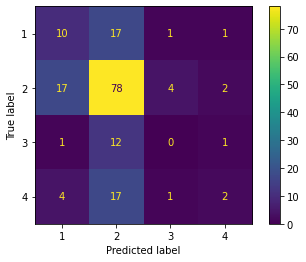

In [48]:
knn = KNeighborsClassifier(n_neighbors = 5, algorithm='ball_tree', leaf_size=30)
knn.fit(train_features, y_train)
plot_confusion_matrix(knn, test_features, y_test)

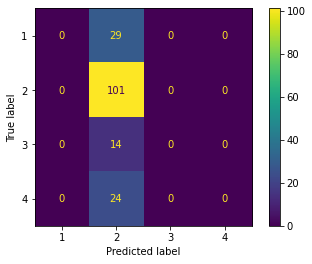

In [49]:
svc = SVC()
svc.fit(train_features, y_train)
plot_confusion_matrix(svc, test_features, y_test)

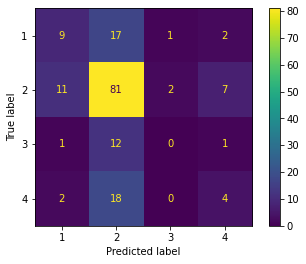

In [50]:
rf = RandomForestClassifier()
rf.fit(train_features, y_train)
plot_confusion_matrix(rf, test_features, y_test)

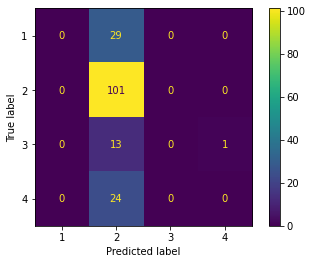

In [51]:
ada = AdaBoostClassifier()
ada.fit(train_features, y_train)
plot_confusion_matrix(ada, test_features, y_test)